<a href="https://colab.research.google.com/github/tohyongyao/AI-Project/blob/master/Mask_R_CNN_Object_Detection_of_Volleyball.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Mask R-CNN - Train on Volleyball Dataset

This notebook was modified from the TrainShape and Inspect Balloon Data notebook to use my own dataset of volleyballs. I have modified the values in the config to suit my dataset. 

Images in the dataset are downloaded from Flickr, Google Images and some of my own photos. 

Annotation is done using the VGG Image Annotator version 2.0.9.



In [1]:
# Restart runtime after downgrading keras to 2.1.0 to prevent compatbility issues.
!pip install q keras==2.1.0

In [1]:
! git clone https://github.com/matterport/Mask_RCNN.git

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 116.75 MiB | 39.25 MiB/s, done.
Resolving deltas: 100% (567/567), done.


In [5]:
cd Mask_RCNN

/content/Mask_RCNN


In [0]:
!mkdir datasets

In [4]:
cd datasets

/content/Mask_RCNN/datasets


In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!unzip -qq /content/gdrive/'My Drive'/'Colab Notebooks'/downloads/dataset_volleyball.zip

In [7]:
cd ..

/content/Mask_RCNN


In [3]:
# Tensorflow Magic
%tensorflow_version 1.x
import tensorflow as tf
import keras
print(tf.__version__)
print(keras.__version__)


1.15.2
2.1.0


In [0]:
import os
import sys
import itertools
import math
import logging
import json
import re
import random
from collections import OrderedDict
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon
import skimage.draw

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log
from mrcnn.config import Config

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

## Configurations

In [7]:
class VolleyballConfig(Config):
    """Configuration for training on the volleyball dataset.
    Derives from the base Config class and overrides values specific
    to the volleyball dataset.
    """
    # Give the configuration a recognizable name
    NAME = "volleyball"

    # Train on 1 GPU. Try fitting 2 images.
    #GPU_COUNT = 1
    IMAGES_PER_GPU = 2

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1 # background + volleyball

    # 
    #RPN_ANCHOR_SCALES = (32, 64, 128, 256, 512)  # anchor side in pixels

    # 
    #TRAIN_ROIS_PER_IMAGE = 200

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100
    
    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9

    
config = VolleyballConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

## Dataset

Load volleyball dataset

Extend the Dataset class and add a method to load the shapes dataset, `load_volleyball()`, and override the following methods:

* load_mask()
* image_reference()

In [0]:
class VolleyballDataset(utils.Dataset):

    def load_volleyball(self, dataset_dir, subset):
        """Load a subset of the Volleyball dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes
        self.add_class("volleyball", 1, "volleyball")
        
        # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)

        # Load annotations
        # VGG Image Annotator (version 2.0.9) saves each image in the form:
        # { 'filename': '28503151_5b5b7ec140_b.jpg',
        #   'size': 100202,
        #   'regions': [
        #       {
        #           'shape_attributes': {
        #               'name':'polygon',
        #               'all_points_x':[...],
        #               'all_points_y':[...]
        #           },
        #           'region_attributes': {}
        #       },
        #       ... more regions ...
        #   ],
        # }

        annotations = json.load(open(os.path.join(dataset_dir, "volleyball.json")))
        annotations = list(annotations.values())  # don't need the dict keys

        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]

        # Add images
        for a in annotations:
            # Get the x, y coordinates of points of the polygons that make up
            # the outline of each object instance. These are stores in the
            # shape_attributes (see json format above)
            # The if condition is needed to support VIA versions 1.x and 2.x.
            if type(a['regions']) is dict:
                polygons = [r['shape_attributes'] for r in a['regions'].values()]
            else:
                polygons = [r['shape_attributes'] for r in a['regions']] 

            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "volleyball",
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "volleyball":
            return info["path"]
        else:
            super(self.__class__).image_reference(self, image_id)

    def load_mask(self, image_id):
        """Generate instance masks for an image.
           There are 3 types of masks: circle, ellipse and polygon.
        """
        info = self.image_info[image_id]
        mask = np.zeros([info['height'], info['width'], len(info["polygons"])], 
                        dtype=np.uint8)
        for i, p in enumerate(info['polygons']):
            if p['name'] == "circle":
              rr, cc = skimage.draw.circle(p['cy'], p['cx'], p['r'])
            if p['name'] == "ellipse":
              rr, cc = skimage.draw.ellipse(p['cy'], p['cx'], p['ry'], p['rx'], rotation=p['theta'])
            if p['name'] == "polygon":  
              rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr,cc,i] = 1   
          
        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)


### Preparing the training and validation datasets

In [9]:
VOLLEYBALL_DIR = "/content/Mask_RCNN/datasets/dataset_volleyball"

# Training dataset
dataset_train = VolleyballDataset()
dataset_train.load_volleyball(VOLLEYBALL_DIR, "train")
dataset_train.prepare()

# Validation dataset
dataset_val = VolleyballDataset()
dataset_val.load_volleyball(VOLLEYBALL_DIR, "val")
dataset_val.prepare()

print("Image Count: {}".format(len(dataset_train.image_ids)))
print("Class Count: {}".format(dataset_train.num_classes))
for i, info in enumerate(dataset_train.class_info):
    print("{:3}. {:50}".format(i, info['name']))

Image Count: 52
Class Count: 2
  0. BG                                                
  1. volleyball                                        


## Visualize images

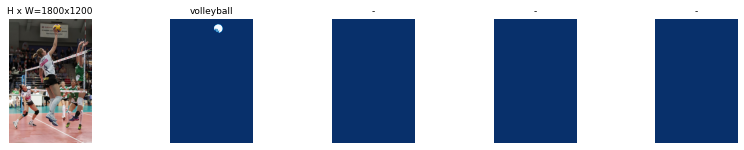

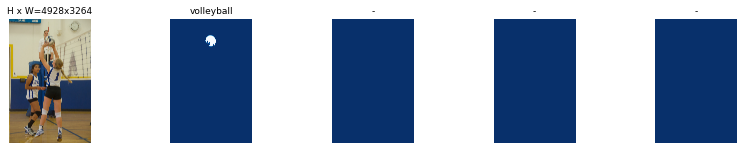

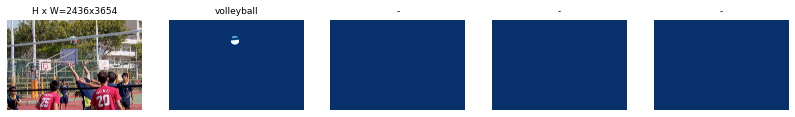

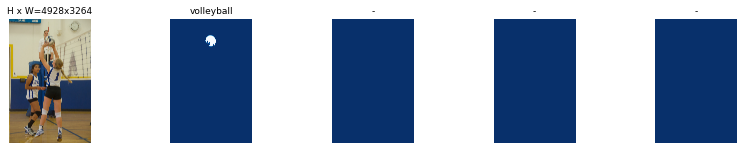

In [14]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

image_id  1 /content/Mask_RCNN/datasets/dataset_volleyball/val/31636344345_860a624619_o.jpg
image                    shape: (3840, 5760, 3)       min:    0.00000  max:  255.00000  uint8
mask                     shape: (3840, 5760, 7)       min:    0.00000  max:    1.00000  bool
class_ids                shape: (7,)                  min:    1.00000  max:    1.00000  int32
bbox                     shape: (7, 4)                min:    0.00000  max: 5752.00000  int32


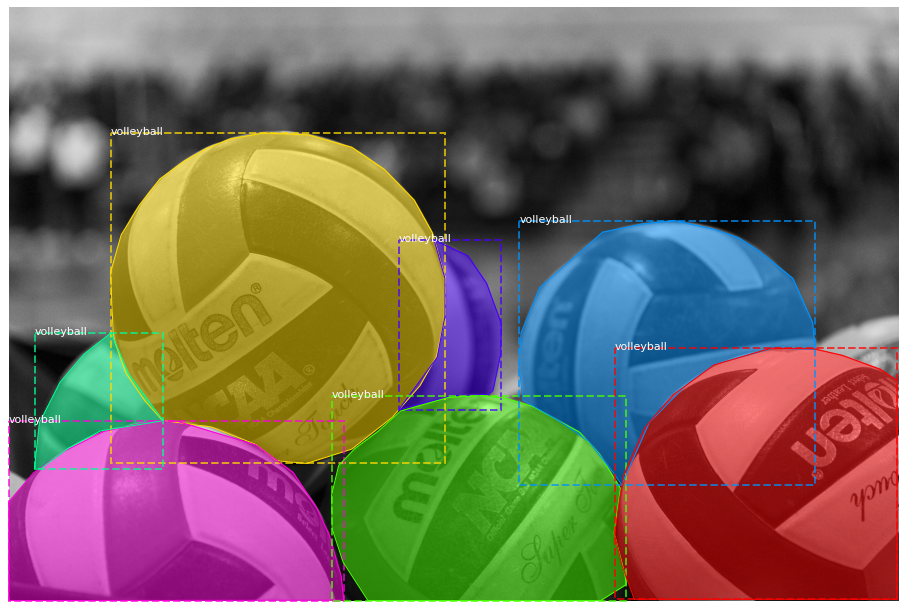

In [15]:
# Load random image and mask.
image_id = random.choice(dataset_val.image_ids)
image = dataset_val.load_image(image_id)
mask, class_ids = dataset_val.load_mask(image_id)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id ", image_id, dataset_val.image_reference(image_id))
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset_val.class_names)

image_id:  40 /content/Mask_RCNN/datasets/dataset_volleyball/train/15229077092_932b612745_o.jpg
Original shape:  (3264, 4928, 3)
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
mask                     shape: (1024, 1024, 1)       min:    0.00000  max:    1.00000  bool
class_ids                shape: (1,)                  min:    1.00000  max:    1.00000  int32
bbox                     shape: (1, 4)                min:  296.00000  max:  394.00000  int32


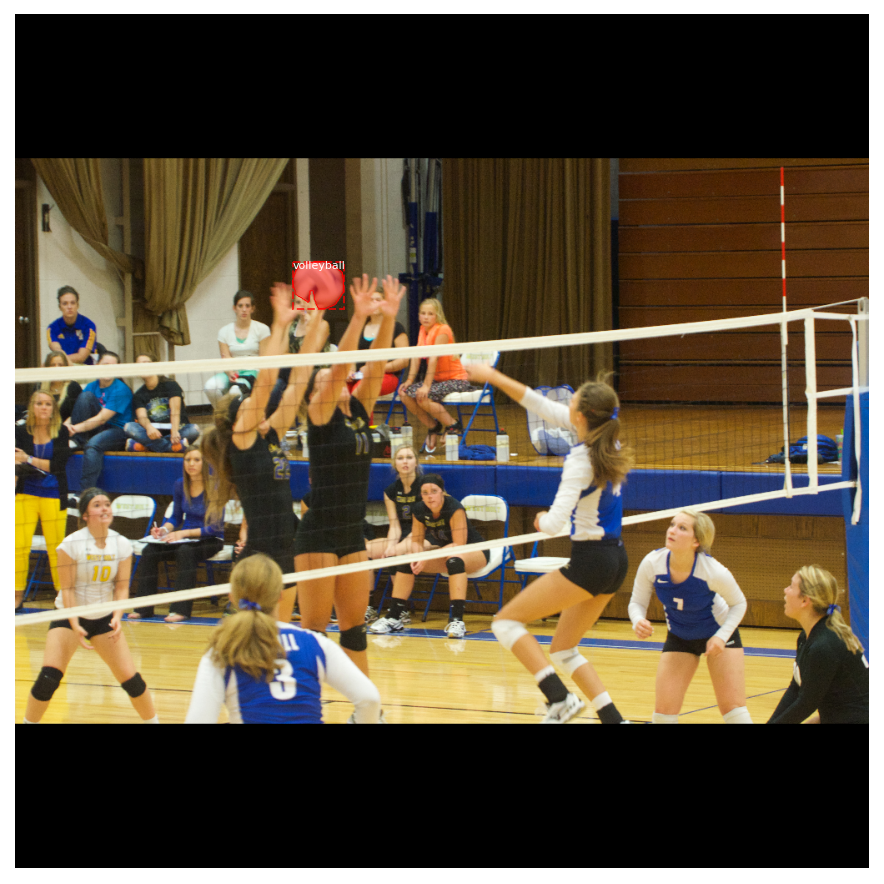

In [16]:
# Load random image and mask.
image_id = np.random.choice(dataset_train.image_ids, 1)[0]
image = dataset_train.load_image(image_id)
mask, class_ids = dataset_train.load_mask(image_id)
original_shape = image.shape
# Resize
image, window, scale, padding, _ = utils.resize_image(
    image, 
    min_dim=config.IMAGE_MIN_DIM, 
    max_dim=config.IMAGE_MAX_DIM,
    mode=config.IMAGE_RESIZE_MODE)
mask = utils.resize_mask(mask, scale, padding)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id: ", image_id, dataset_train.image_reference(image_id))
print("Original shape: ", original_shape)
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset_train.class_names)

## Create Model

In [10]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config, model_dir=MODEL_DIR)






Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


In [11]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

## Training



In [12]:
# Training only the heads layer would be sufficient
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=30, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /logs/volleyball20200519T1132/mask_rcnn_volleyball_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         

In [0]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
# model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
# model.keras_model.save_weights(model_path)

In [0]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Detection

In [14]:
class InferenceConfig(VolleyballConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)



Instructions for updating:
Use `tf.cast` instead.
Loading weights from  /logs/volleyball20200519T1132/mask_rcnn_volleyball_0030.h5
Re-starting from epoch 30


original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
image_meta               shape: (14,)                 min:    0.00000  max: 1280.00000  float64
gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (1, 4)                min:  249.00000  max:  545.00000  int32
gt_mask                  shape: (1024, 1024, 1)       min:    0.00000  max:    1.00000  bool


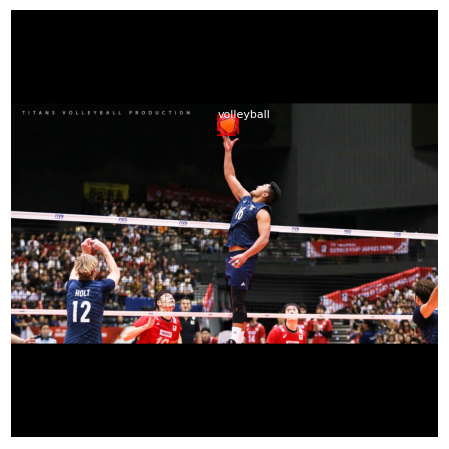

In [15]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


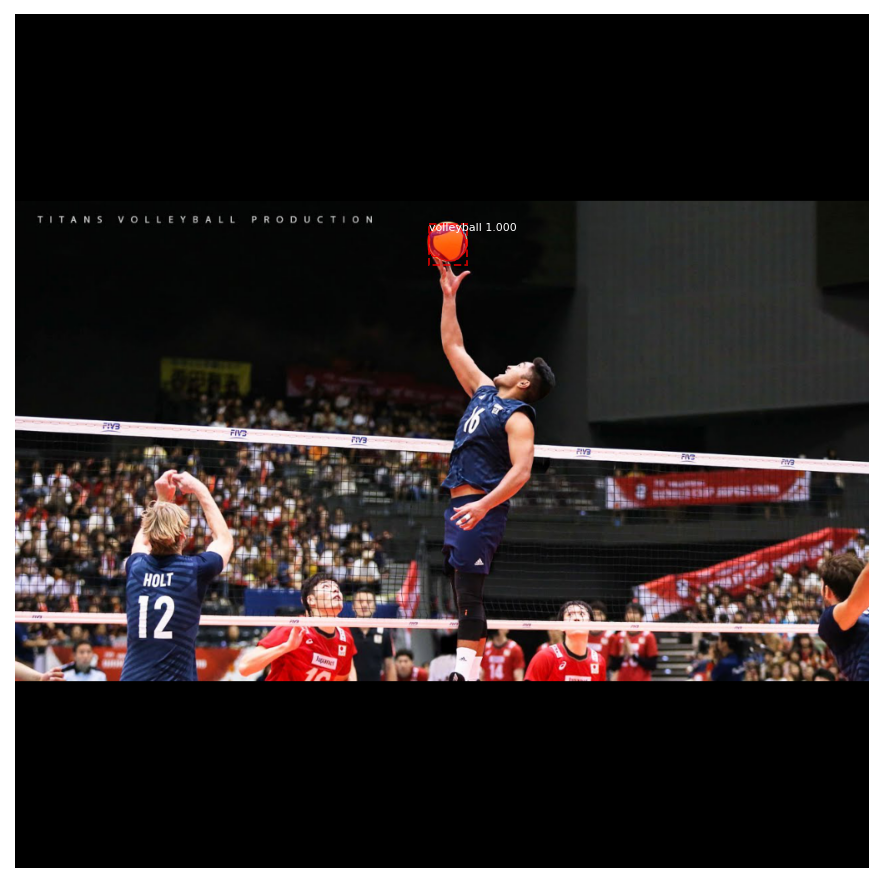

In [18]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

## Evaluation

In [19]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.9714285731315613
